In [2]:
import os
import sys
import numpy as np
import copy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [3]:

class Fluid:
    
    def __init__(self, rho, nu):
        self.rho = rho
        self.nu  = nu


In [4]:

class Boundary:
    
    def __init__(self, left, right, top, bottom):
        self.left   = left
        self.right  = right
        self.top    = top
        self.bottom = bottom
        

In [5]:

class Space:
    
    def __init__(self, nrows, ncols, breadth, length):
        
        self.nrows   = nrows                      # domain gridpoints nx
        self.ncols   = ncols                      # domain gridpoints ny
        self.length  = length
        self.breadth = breadth
        self.dx      = length  / (ncols - 1)      # grid step on x direction (dx)
        self.dy      = breadth / (nrows - 1)      # grid step on y direction (dy)
        self.create_mesh(nrows, ncols)            # create all required grids
    
    
    
    def create_mesh(self, nrows, ncols):
        
        # Velocity matrices
        self.u      = np.zeros((self.nrows+2, self.ncols+2))    # velocity in the x direction
        self.v      = np.zeros((self.nrows+2, self.ncols+2))    # velocity in the y direction
        self.u_star = np.zeros((self.nrows+2, self.ncols+2))    # horizontal velocity used to compute pressure
        self.v_star = np.zeros((self.nrows+2, self.ncols+2))    # vertical velocity used to compute pressure
        self.u_next = np.zeros((self.nrows+2, self.ncols+2))    # next velocity in the x direction 
        self.v_next = np.zeros((self.nrows+2, self.ncols+2))    # next velocity in the y direction
        self.u_c    = np.zeros((self.nrows, self.ncols))        # horizontal velocity at inner grid (center) points
        self.v_c    = np.zeros((self.nrows, self.ncols))        # vertical velocity at inner grid points
        
        # Pressure matrices
        self.p   = np.zeros((self.nrows+2, self.ncols+2))       # pressure on entire grid
        self.p_c = np.zeros((self.nrows, self.ncols))           # pressure only at inner points of the grid

        
        
        
    '''
    The next three function sets the boundary conditions for the determined array of the space class.
    '''
    def SetUBoundary(self, boundary):
        self.u[:, 0] = boundary.left
        self.u[:,-1] = boundary.right
        self.u[-1,:] = boundary.top
        self.u[0 ,:] = boundary.bottom
        

    def SetVBoundary(self, boundary):
        self.v[:, 0] = boundary.left
        self.v[:,-1] = boundary.right
        self.v[-1,:] = boundary.top
        self.v[0 ,:] = boundary.bottom
        
        
    def SetPBoundary(self, boundary):
        self.p[:, 0] = boundary.left
        self.p[:,-1] = boundary.right
        self.p[-1,:] = boundary.top
        self.p[0 ,:] = boundary.bottom



In [6]:
class FluidSimulation:
    
    def __init__(self, dt, time, step):
        self.dt      = dt
        self.t       = 0
        self.time    = time
        self.step    = step
        self.nframes = int(time/(dt*step))
        self.us      = []
        self.vs      = []
        self.ps      = []
        
    
    
    '''
    These two functions use finite difference scheme to compute the derivative of an
    array with respect to the variable x or y.
    '''
    def computeDx(self, spaceArray, dx):
        return (spaceArray[1:-1, 2: ] - spaceArray[1:-1, :-2]) / (2 * dx)


    def computeDy(self, spaceArray, dy):
        return (spaceArray[2: , 1:-1] - spaceArray[ :-2, 1:-1]) / (2 * dy)


    '''
    These two functions compute the second derivatives of array-functions with respect
    to x or y twice. It uses the 2nd order centered differences method.
    '''
    def computeDxx(self, spaceArray, dx):
        return (spaceArray[1:-1, 2: ] - 2*spaceArray[1:-1, 1:-1] + spaceArray[1:-1, :-2]) / (dx**2)


    def computeDyy(self, spaceArray, dy):
        return (spaceArray[2: , 1:-1] - 2*spaceArray[1:-1, 1:-1] + spaceArray[ :-2, 1:-1]) / (dy**2)
    
    
    
    
    '''
    This function is used to get starred u and v velocities at time step t
    '''
    def GetStarredVelocities(self, space, fluid):

        # Save object attributes as local variable with explicity typing for improved readability
        u    = space.u.astype(float, copy=False)
        v    = space.v.astype(float, copy=False)
        dx   = float(space.dx)
        dy   = float(space.dy)
        dt   = float(self.dt)
        rho  = float(fluid.rho)
        nu   = float(fluid.nu)

        # Copy u and v to new variables u_star and v_star
        u_star = u.copy()
        v_star = v.copy()

        # Calculate derivatives of u and v using the finite difference scheme 
        u1x = self.computeDx(u, dx)
        u1y = self.computeDy(u, dy)
        u2x = self.computeDxx(u, dx)
        u2y = self.computeDyy(u, dy)
        v1x = self.computeDx(v, dx)
        v1y = self.computeDy(v, dy)
        v2x = self.computeDxx(v, dx)
        v2y = self.computeDyy(v, dy)

        # Computing starred velocities
        u_star[1:-1, 1:-1] = u[1:-1, 1:-1] - dt*(u[1:-1, 1:-1]*u1x + v[1:-1, 1:-1]*u1y) + dt*nu*(u2x + u2y)
        v_star[1:-1, 1:-1] = v[1:-1, 1:-1] - dt*(u[1:-1, 1:-1]*v1x + v[1:-1, 1:-1]*v1y) + dt*nu*(v2x + v2y)

        # Save the calculated starred velocities to the space object 
        space.u_star = u_star.copy()
        space.v_star = v_star.copy()    



    '''
    This function is used to iteratively solve the pressure Poisson equation using the
    starred velocities to calculate pressure at (t + dt)
    '''
    def SolvePressurePoisson(self, space, fluid, pBoundary):

        # Save object attributes as local variable with explicity typing for improved readability
        u_star = space.u_star.astype(float, copy=False)
        v_star = space.v_star.astype(float, copy=False)
        p      = space.p.astype(float, copy=False)
        dx     = float(space.dx)
        dy     = float(space.dy)
        dt     = float(self.dt)
        rho    = float(fluid.rho)

        # evaluate derivative of starred velocities
        u_star1x = self.computeDx(u_star, dx)
        v_star1y = self.computeDy(v_star, dy)

        # compute equation's terms
        b = (rho/dt)*(u_star1x + v_star1y)
        term1 = (p[1:-1,  :-2] + p[1:-1, 2: ])*dy**2
        term2 = (p[ :-2, 1:-1] + p[2: , 1:-1])*dx**2
        term3 = - b*(dx**2*dy**2)

        # get next pressure at center grids
        p[1:-1, 1:-1] = (term1 + term2 + term3) / (2*(dx**2 + dy**2))
        space.p_c = p[1:-1, 1:-1] 
        space.SetPBoundary(pBoundary)
        


    '''
    This function is the corrector step. It uses the starred velocities and the computed pressure
    to update the velocities at the next timestep.
    '''
    def SolveMomentumEquation(self, space, fluid):

        # save object attributes as local variable with explicity typing for improved readability
        u_star = space.u_star.astype(float, copy=False)
        v_star = space.v_star.astype(float, copy=False)
        u      = space.u.astype(float, copy=False)
        v      = space.v.astype(float, copy=False)
        p      = space.p.astype(float, copy=False)
        dx     = float(space.dx)
        dy     = float(space.dy)
        dt     = float(self.dt)
        rho    = float(fluid.rho)

        # evaluate first derivative of pressure in x and y directions
        p1x = self.computeDx(p, dx)
        p1y = self.computeDy(p, dy)

        # calculate u and v at next timestep
        u[1:-1, 1:-1] = u_star[1:-1, 1:-1] - (dt/rho)*p1x
        v[1:-1, 1:-1] = v_star[1:-1, 1:-1] - (dt/rho)*p1y
        space.u_c = u[1:-1, 1:-1]
        space.v_c = v[1:-1, 1:-1]
        
        
        
    def update(self, space, fluid, boundaries, hide_status = True):
        
        uBoundary, vBoundary, pBoundary = boundaries
        t, i = 0, 0
        
        while t < self.time:
            
            # Print simulation status
            if not hide_status:
                sys.stdout.write("\rSimulation time left: {0:.2f}".format(time - t))
                sys.stdout.flush()
            
            # Set boundary conditions
            space.SetUBoundary(uBoundary)
            space.SetVBoundary(vBoundary)
            space.SetPBoundary(pBoundary)
            
            # Solve N-S equations
            self.GetStarredVelocities(space, fluid)                # calculate starred velocities
            self.SolvePressurePoisson(space, fluid, pBoundary)     # solve the pressure Poisson equation
            self.SolveMomentumEquation(space, fluid)               # solve the momentum equation
            
            # Append center of arrays to list of states
            if i % self.step == 0:
                self.us.append(copy.deepcopy(space.u_c))
                self.vs.append(copy.deepcopy(space.v_c))
                self.ps.append(copy.deepcopy(space.p_c))
            
            # advance time step of simulation
            t += self.dt
            i += 1
            
            
            
            
    def visualize(self, space, fluid, boundaries):
        u = space.u_c
        v = space.v_c
        p = space.p_c

        #Create mesh for X and Y inputs to the figure
        x = np.linspace(0, space.length, space.ncols)
        y = np.linspace(0, space.breadth, space.nrows)
        X, Y = np.meshgrid(x,y)

        # Create subplots for velocity and pressure fields
        fig, axs = plt.subplots(1, 3, figsize=(16, 4))
        fig.suptitle(f'n = {int(self.time/self.dt)};  ν = {fluid.nu};  $u_0$ = {boundaries[0].top}', fontsize = 15)
        fig.subplots_adjust(top = 0.80)
        
        im1 = axs[0].contourf(X, Y, u, alpha=0.8, cmap=cm.viridis)
        axs[0].set_title("U velocity field")
        fig.colorbar(im1, ax = axs[0])
        
        im2 = axs[1].contourf(X, Y, v, alpha=0.8, cmap=cm.viridis)
        axs[1].set_title("V velocity field")
        fig.colorbar(im2, ax = axs[1])
        
        axs[2].set_title("Pressure field")
        axs[2].set_xlim([0, space.length])
        axs[2].set_ylim([0, space.breadth])
        axs[2].streamplot(X, Y, u, v, color = "royalblue")
        im3 = axs[2].contourf(X, Y, p, alpha=0.8, cmap=cm.viridis)
        fig.colorbar(im3, ax = axs[2])
        plt.show()
        

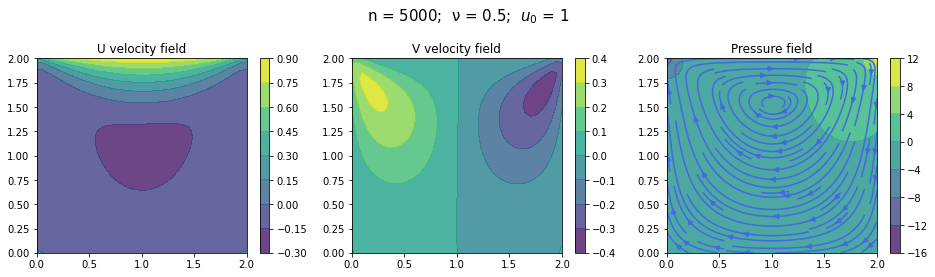

In [7]:
######################
## SPACE PROPERTIES ##
######################

length  = 2        # length of computational domain in the x-direction
breadth = 2        # breadth of computational domain in the y-direction
ncols   = 41       # number of grid points in the x-direction (KEEP ODD)
nrows   = 41       # number of grid points in the y-direction (KEEP ODD)

# Initialize an object of class space
cavity = Space(nrows, ncols, breadth, length)


######################
## FLUID PROPERTIES ##
######################

rho = 1       # Density of fluid
nu  = 0.5     # Viscosity of fluid

# Initialize object of class fluid
water = Fluid(rho, nu)


#########################
## BOUNDARY CONDITIONS ##
#########################

uLeft   = 0
uRight  = 0
uTop    = 1     # lid
uBottom = 0

vLeft   = 0
vRight  = 0
vTop    = 0    # lid
vBottom = 0

pLeft   = cavity.p[:,1]
pRight  = cavity.p[:,-2]
pTop    = cavity.p[-2,:]
pBottom = cavity.p[1,:]


# Initialize boundaries and saving to list
uBoundary  = Boundary(uLeft, uRight, uTop, uBottom)
vBoundary  = Boundary(vLeft, vRight, vTop, vBottom)
pBoundary  = Boundary(pLeft, pRight, pTop, pBottom)
boundaries = [uBoundary, vBoundary, pBoundary]


###########################
## SIMULATION PARAMETERS ##
###########################

time = 5           # Simulation time
dt   = 0.001       # time step of simulation
step = 100         # skip steps when saving values for animation

# Initializing and running simulation for 3 seconds
sim = FluidSimulation(dt, time, step)
sim.update(cavity, water, boundaries, hide_status = True)
sim.visualize(cavity, water, boundaries)

In [8]:
def animate(i):
   
    #Print frames left to be added to the animation
    sys.stdout.write("\rFrames remaining: {0:03d}".format(sim.nframes - (i+1)))
    sys.stdout.flush()
    
    # get pressure and velocities at a timestep
    u, v, p = sim.us[i], sim.vs[i], sim.ps[i]
    
    # make contour and stream plots for current iteration
    ax.clear()
    ax.set_xlim([0, length])
    ax.set_ylim([0, breadth])
    ax.set_xlabel("$x$", fontsize=12)
    ax.set_ylabel("$y$", fontsize=12)
    ax.set_title("Frame No: {0}".format(i+1))
    cont = ax.contourf(X, Y, p, cmap = cm.viridis, alpha=0.8)
    stream = ax.streamplot(X, Y, u, v, color = "royalblue")
    return cont, stream


######## Making FlowPy Animation ########
#########################################
Frames remaining: 000
Animation saved as FluidFlowAnimation.gif


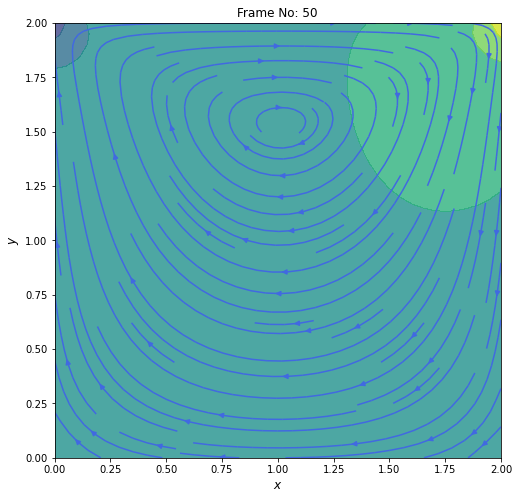

In [9]:
# Create mesh for X and Y inputs to the figure
x = np.linspace(0, length, ncols)
y = np.linspace(0, breadth, nrows)
X, Y = np.meshgrid(x, y)

#Create blank figure
fig = plt.figure(figsize = (8, 8))
ax  = plt.axes(xlim = (0, length), ylim = (0, breadth))

# Making animation
print("######## Making FlowPy Animation ########")
print("#########################################")

anim = FuncAnimation(fig, animate, frames = sim.nframes, interval = 100, blit = False)
anim.save("FluidFlowAnimation.gif", writer = PillowWriter(fps = 10))

print("\nAnimation saved as FluidFlowAnimation.gif")

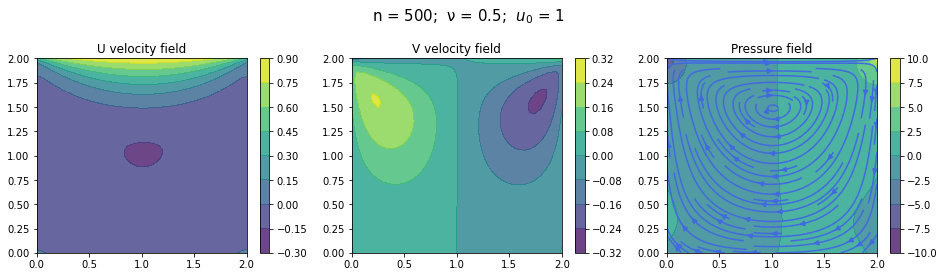

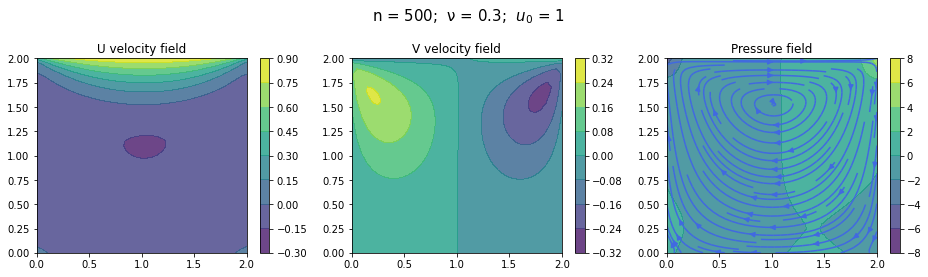

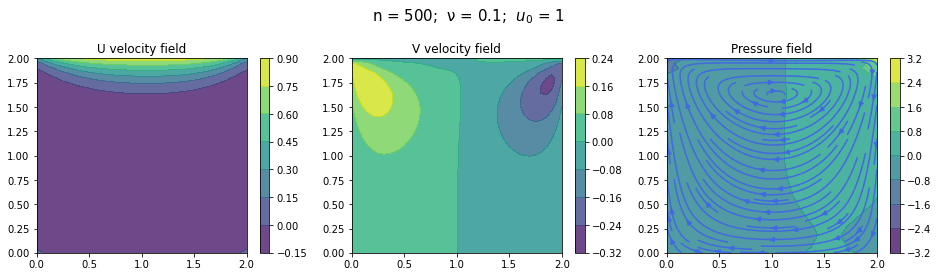

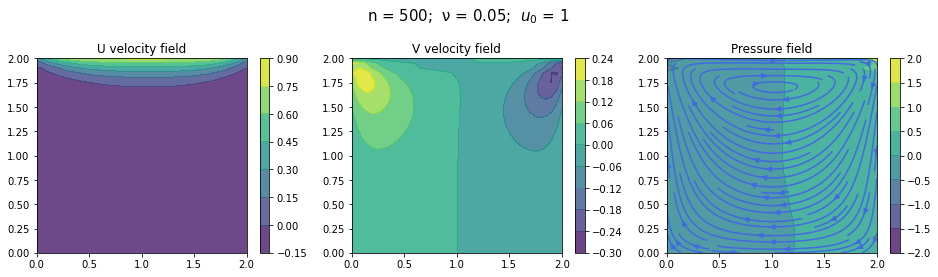

In [9]:
# Keeping other parameters the same
time = 0.5
dt   = 0.001
step = 100
length  = 2        
breadth = 2        
ncols   = 41       
nrows   = 41       
rho = 1
uLeft, uRight, uTop, uBottom = 0, 0, 1, 0
vLeft, vRight, vTop, vBottom = 0, 0, 0, 0

# Different viscosities
nus = [0.5, 0.3, 0.1, 0.05]     

for idx, nu in enumerate(nus):
    
    # Initialize an object of class space
    cavity = Space(nrows, ncols, breadth, length)
    pLeft, pRight, pTop, pBottom = cavity.p[:,1], cavity.p[:,-2], 0, cavity.p[1,:]
    
    # Initialize boundaries and saving to list
    uBoundary  = Boundary(uLeft, uRight, uTop, uBottom)
    vBoundary  = Boundary(vLeft, vRight, vTop, vBottom)
    pBoundary  = Boundary(pLeft, pRight, pTop, pBottom)
    boundaries = [uBoundary, vBoundary, pBoundary]

    # Initialize object of class fluid
    water = Fluid(rho, nu)

    # Initializing simulation class
    sim = FluidSimulation(dt, time, step)
    sim.update(cavity, water, boundaries)
    sim.visualize(cavity, water, boundaries)

The higher the viscosity of the fluid the more influence the liquid in the lid will have on liquids under it (and vice-versa), better sharing its velocity among more grids of the simulation. This better sharing velocity can be seen from the $u$ velocity plot, where the velocities for the grids under the lid are higher for hugher viscosity values. This means that more liquid will hit the upper-right corner of the graph as more is pushed by the lid velocity, and thus the pressure there shall be bigger for larger viscosity values. The turn (the liquid "doing 360s") is wider due to this velocity sharing for higher viscosity values.

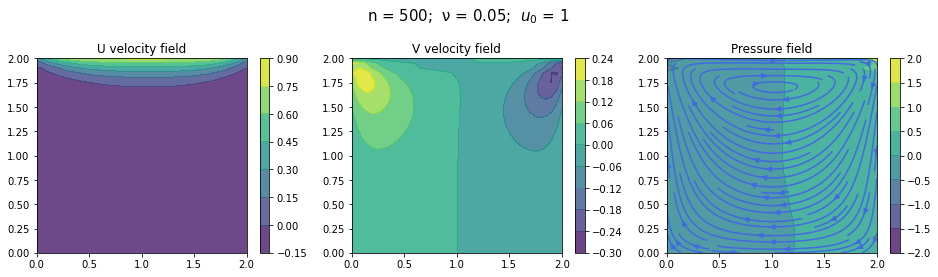

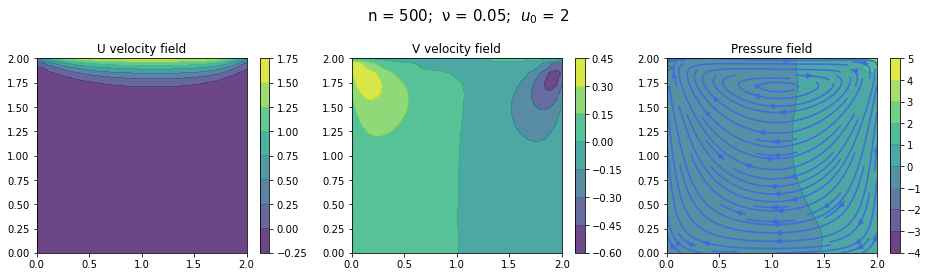

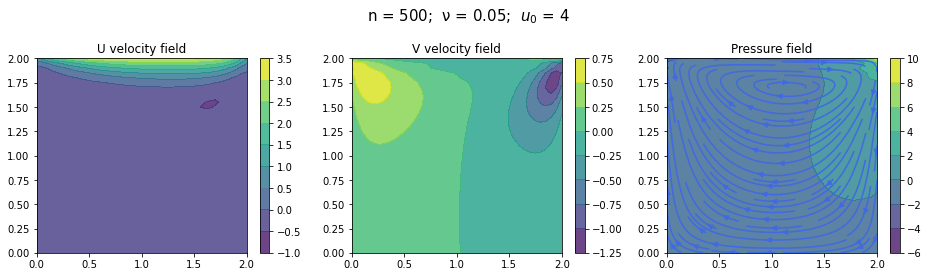

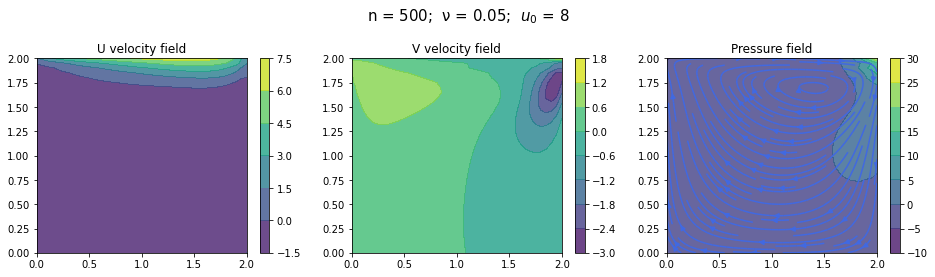

In [10]:
# Keeping other parameters the same
time = 0.5
dt   = 0.001
step = 100
length  = 2        
breadth = 2        
ncols   = 41       
nrows   = 41       
rho = 1
nu = 0.05
uLeft, uRight, uTop, uBottom = 0, 0, 1, 0
vLeft, vRight, vTop, vBottom = 0, 0, 0, 0

# Different lid velocities
uTops = [1, 2, 4, 8]

for uTop in uTops:

    # Initialize an object of class space
    cavity = Space(nrows, ncols, breadth, length)
    pLeft, pRight, pTop, pBottom = cavity.p[:,1], cavity.p[:,-2], 0, cavity.p[1,:]

    # Initialize boundaries and saving to list
    uBoundary  = Boundary(uLeft, uRight, uTop, uBottom)
    vBoundary  = Boundary(vLeft, vRight, vTop, vBottom)
    pBoundary  = Boundary(pLeft, pRight, pTop, pBottom)
    boundaries = [uBoundary, vBoundary, pBoundary]

    # Initialize object of class fluid
    water = Fluid(rho, nu)

    # Initializing simulation class
    sim = FluidSimulation(dt, time, step)
    sim.update(cavity, water, boundaries)
    sim.visualize(cavity, water, boundaries)

In all plots (except the special case when $u_0 = 0$), we can see that at the place where the water from the lid hits a vertical boundary (i.e. the upper right corner of the graph), the pressure is higher than compared to the left portion of the graph and the $v$ velocity is very low. The first observation makes sense as the $u$ lid velocity captures the surrounding water and sends it to the right, which means that there is much less water on the upper left corner of the graph as the lid pulls the water to the right (and, equivalently, the pressure should be much higher on the upper-right corner). 

The second observation makes sense because the first one is valid -- since the pressure is higher on the upper-right corner, the $v$ velocity there should be very slow as that is the location where the water hits the wall the hardest, spreading around in both the up and down directions, canceling each other out. However, since the water can't accumulate in that region of the plot as there is a big difference in pressure compared to the other parts of the plot, the wtaer needs to flow out of there. Since the pressure is lower in the upper-left corner, the water needs to get there, but the water doesn't go there straight away since it has a big portion of its velocity to the right reflected down due to the collision. Thus, also due to the water's viscosity, the fluid needs to make a somewhat circular motion. The $v$ velocity on the upper-left corner is bigger than in other parts of the graph since the pressure there is the smallest overall due to water being pulled out.

We can see from the multiple plots that the higher the lid velocity, denoted as $u_0$, the higher the pressure generated at the upper right corner due to the liquid hitting the wall. This higher difference in pressure on the upper right corner between the plots lead to a larger difference in $v$ velocities in different regions within a plot. Thus, increasing $u_0$ leads to higher pressure and velocities differences within a plot.

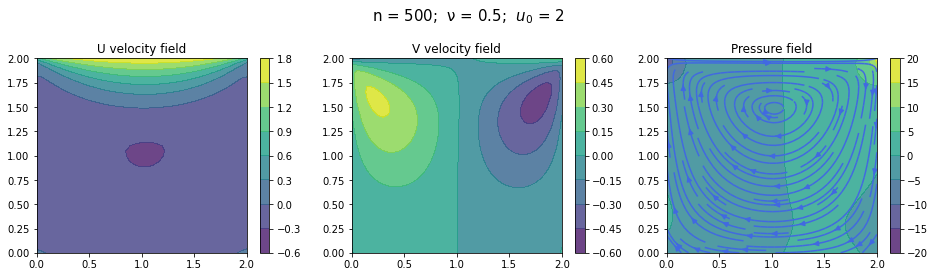

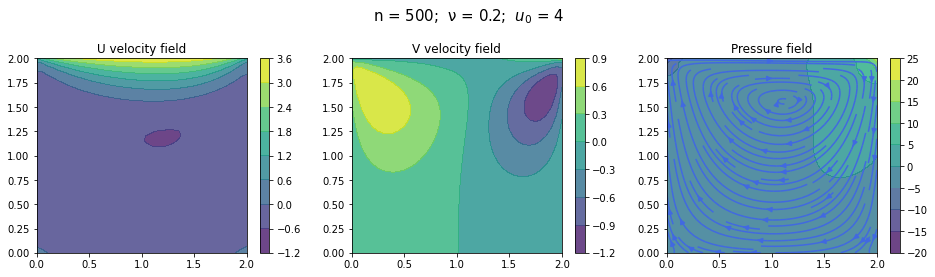

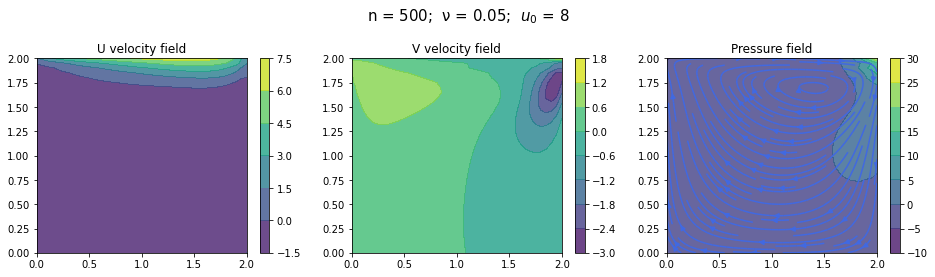

In [11]:
# Keeping other parameters the same
time = 0.5
dt   = 0.001
step = 100
length  = 2        
breadth = 2        
ncols   = 41       
nrows   = 41       
rho = 1
nu = 0.05
uLeft, uRight, uTop, uBottom = 0, 0, 1, 0
vLeft, vRight, vTop, vBottom = 0, 0, 0, 0

# Different lid velocities
uTops = [2, 4, 8]
nus   = [0.5, 0.2, 0.05]
for (uTop, nu) in zip(uTops, nus):

    # Initialize an object of class space
    cavity = Space(nrows, ncols, breadth, length)
    pLeft, pRight, pTop, pBottom = cavity.p[:,1], cavity.p[:,-2], 0, cavity.p[1,:]

    # Initialize boundaries and saving to list
    uBoundary  = Boundary(uLeft, uRight, uTop, uBottom)
    vBoundary  = Boundary(vLeft, vRight, vTop, vBottom)
    pBoundary  = Boundary(pLeft, pRight, pTop, pBottom)
    boundaries = [uBoundary, vBoundary, pBoundary]

    # Initialize object of class fluid
    water = Fluid(rho, nu)

    # Initializing simulation class
    sim = FluidSimulation(dt, time, step)
    sim.update(cavity, water, boundaries)
    sim.visualize(cavity, water, boundaries)

The Reynolds number is given by $Re = u_{0} L/\nu$, where we use $u_0 = U_{lid}$. To increase the Re number, we need to either increase the lid velocity, decrease the viscosity, or do both at the same time. Increasing $u_0$ and decreasing $\nu$, from the observations above, mean that the liquid should turn faster. This behavior can be observed from the plots above, where increasingly larger Re numbers are plotted and we can see that both the $u$ and the $v$ velocities gain larger magnitudes, and the difference in pressure becomes larger and larger, meaning that the liquid turns much faster.

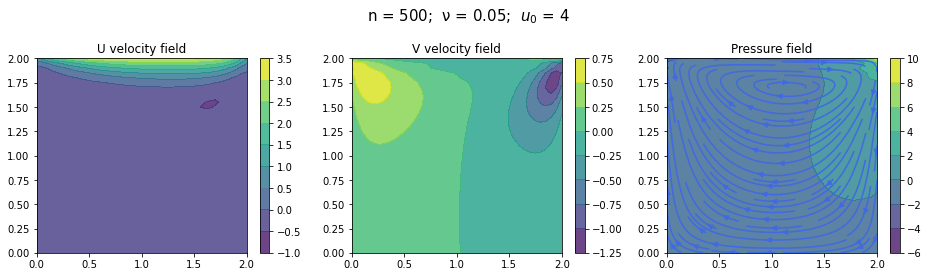

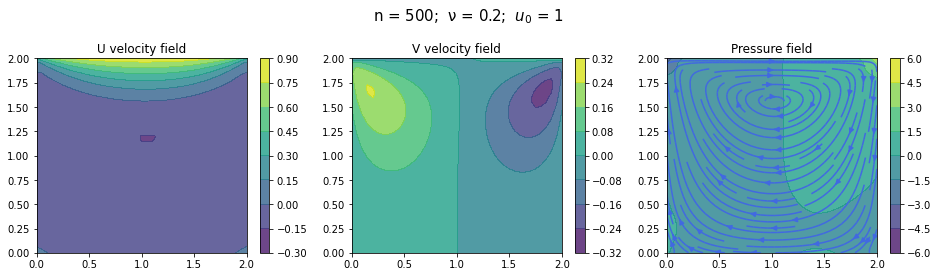

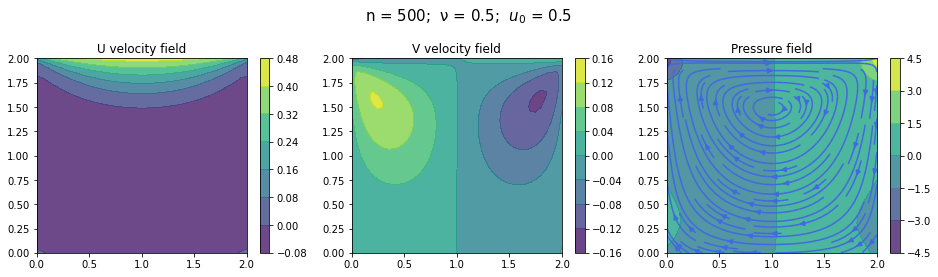

In [14]:
# Keeping other parameters the same
time = 0.5
dt   = 0.001
step = 100
length  = 2        
breadth = 2        
ncols   = 41       
nrows   = 41       
rho = 1
nu = 0.05
uLeft, uRight, uTop, uBottom = 0, 0, 1, 0
vLeft, vRight, vTop, vBottom = 0, 0, 0, 0

# Different lid velocities
uTops = [4, 1, 0.5]
nus   = [0.05, 0.2, 0.5]
for (uTop, nu) in zip(uTops, nus):

    # Initialize an object of class space
    cavity = Space(nrows, ncols, breadth, length)
    pLeft, pRight, pTop, pBottom = cavity.p[:,1], cavity.p[:,-2], 0, cavity.p[1,:]

    # Initialize boundaries and saving to list
    uBoundary  = Boundary(uLeft, uRight, uTop, uBottom)
    vBoundary  = Boundary(vLeft, vRight, vTop, vBottom)
    pBoundary  = Boundary(pLeft, pRight, pTop, pBottom)
    boundaries = [uBoundary, vBoundary, pBoundary]

    # Initialize object of class fluid
    water = Fluid(rho, nu)

    # Initializing simulation class
    sim = FluidSimulation(dt, time, step)
    sim.update(cavity, water, boundaries)
    sim.visualize(cavity, water, boundaries)

Conversely, lowering the Re number means that we should either decrease the lid velocity, increase the viscosity, or do both at the same time. The lower Re number results in a lower difference in pressure between different regions of the plot, which means lower velocity differences and the turning of the liquid becomes wider. This is supported by the graphs, as we can see the colorbars having decreased magnitudes as we lower Re, and by the streamplot (arrows lines on pressure field) which make wider circles.